In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix, coo_matrix

# Детерминированные алгоритмы
from implicit.nearest_neighbours import ItemItemRecommender, CosineRecommender, TFIDFRecommender, BM25Recommender

# Метрики
from implicit.evaluation import train_test_split
#from implicit.evaluation import precision_at_k, mean_average_precision_at_k, AUC_at_k, ndcg_at_k

import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('retail_train.csv')
data.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [3]:
test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

### Задание 1. Weighted Random Recommendation

Напишите код для случайных рекоммендаций, в которых вероятность рекомендовать товар прямо пропорциональна логарифму продаж
- Можно сэмплировать товары случайно, но пропорционально какому-либо весу
- Например, прямопропорционально популярности. Вес = log(sales_sum товара)

In [4]:
def weighted_random_recommendation(items_weights, n=5):
    """Случайные рекоммендации
    
    Input
    -----
    items_weights: pd.DataFrame
        Датафрейм со столбцами item_id, weight. Сумма weight по всем товарам = 1
    """
    
    # Подсказка: необходимо модифицировать функцию random_recommendation()
    items = np.array(items_weights['item_id'])
    weights = np.array(items_weights['weight'])
    recs = np.random.choice(items, size=n, replace=False, p=weights)
    
    return recs.tolist()

In [5]:
popularity = data_train.groupby('item_id')['sales_value'].sum().reset_index()
popularity.sort_values('sales_value', ascending=False, inplace=True)
# поскольку сумма весов должна быть равна 1, удобнее присвоить веса исходя из доли в общей сумме продаж:
popularity['weight'] = popularity['sales_value'] / popularity['sales_value'].sum()
popularity['weight'].sum()

1.0

In [6]:
items_weights = popularity.copy()
items_weights.drop('sales_value', axis=1, inplace=True)

In [7]:
result = pd.read_csv('predictions_basic.csv')
result['weighted_random_recommendation'] = result['user_id'].apply(lambda x: weighted_random_recommendation(items_weights, n=5))
result['weighted_random_recommendation'][0]

[9296853, 825665, 844424, 890610, 1134483]

### Задание 2. Расчет метрик
Рассчитайте Precision@5 для каждого алгоритма с помощью функции из вебинара 1. Какой алгоритм показывает лучшее качество?

In [8]:
#result = pd.read_csv('../predictions/predictions_basic.csv')
result.head(2)

,user_id,actual,random_recommendation,popular_recommendation,itemitem,cosine,tfidf,own_purchases,weighted_random_recommendation
0,1,[ 821867 834484 856942 865456 889248 ...,"[8157117, 870291, 1846901, 891748, 1038560]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 1127831, 995242, 1098066]","[1082185, 981760, 1127831, 1098066, 961554]","[1082185, 981760, 1127831, 1098066, 961554]","[1082185, 1029743, 995785, 1004906, 1081177]","[9296853, 825665, 844424, 890610, 1134483]"
1,3,[ 835476 851057 872021 878302 879948 ...,"[1000965, 10121560, 9878622, 13512901, 13039531]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 1098066, 995242, 826249]","[1082185, 1098066, 981760, 826249, 883404]","[1082185, 981760, 1098066, 826249, 883404]","[1082185, 1098066, 6534178, 1127831, 1068719]","[13094965, 7168383, 12949524, 6534178, 936508]"


In [9]:
# поскольку элементы подгружаются из csv строками, преобразуем их:
for i in range(result.shape[0]):
    result['actual'][i] = [int(x) for x in result['actual'][i].replace("[", "").replace("]", "").replace("\n", "").replace(",", " ").replace("   ", " ").replace("  ", " ").split(" ")[1:]]
    result['random_recommendation'][i] = [int(x) for x in result['random_recommendation'][i][1:-1].split(", ")]
    result['popular_recommendation'][i] = [int(x) for x in result['popular_recommendation'][i][1:-1].split(", ")]
    result['itemitem'][i] = [int(x) for x in result['itemitem'][i][1:-1].split(", ")]
    result['cosine'][i] = [int(x) for x in result['cosine'][i][1:-1].split(", ")]
    result['tfidf'][i] = [int(x) for x in result['tfidf'][i][1:-1].split(", ")]
    result['own_purchases'][i] = [int(x) for x in result['own_purchases'][i].replace("[", "").replace("]", "").replace("\n", "").replace(",", " ").replace("   ", " ").replace("  ", " ").split(" ")[1:]]
result.head(2)

,user_id,actual,random_recommendation,popular_recommendation,itemitem,cosine,tfidf,own_purchases,weighted_random_recommendation
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[8157117, 870291, 1846901, 891748, 1038560]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 1127831, 995242, 1098066]","[1082185, 981760, 1127831, 1098066, 961554]","[1082185, 981760, 1127831, 1098066, 961554]","[1029743, 995785, 1004906, 1081177]","[9296853, 825665, 844424, 890610, 1134483]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[1000965, 10121560, 9878622, 13512901, 13039531]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 1098066, 995242, 826249]","[1082185, 1098066, 981760, 826249, 883404]","[1082185, 981760, 1098066, 826249, 883404]","[1098066, 6534178, 1127831, 1068719]","[13094965, 7168383, 12949524, 6534178, 936508]"


In [10]:
def precision_at_k(recommended_list, bought_list, k=5):
    
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list[:k])
    
    flags = np.isin(recommended_list, bought_list)
    
    precision = flags.sum() / len(recommended_list)
    
    return precision

In [11]:
# посчитаем метрики precision_at_k:
result.apply(lambda row: precision_at_k(row['random_recommendation'], row['actual']), axis=1).mean()

0.0005876591576885406

In [12]:
result.apply(lambda row: precision_at_k(row['popular_recommendation'], row['actual']), axis=1).mean()

0.15357492654260343

In [13]:
result.apply(lambda row: precision_at_k(row['itemitem'], row['actual']), axis=1).mean()

0.15112634671890113

In [14]:
result.apply(lambda row: precision_at_k(row['cosine'], row['actual']), axis=1).mean()

0.15533790401566883

In [15]:
result.apply(lambda row: precision_at_k(row['tfidf'], row['actual']), axis=1).mean()

0.16111655239960618

In [16]:
result.apply(lambda row: precision_at_k(row['own_purchases'], row['actual']), axis=1).mean()

0.16001969473165928

In [17]:
result.apply(lambda row: precision_at_k(row['weighted_random_recommendation'], row['actual']), axis=1).mean()

0.02340842311459359

### Задание 3*. Улучшение бейзлайнов и ItemItem

- Попробуйте улучшить бейзлайны, считая их на топ- {2000, 5000, 10000} товаров. Постройте график зависимости precision@5 от топ-*
- Попробуйте улучшить разные варианты ItemItemRecommender, выбирая число соседей $K$. Постройте график зависимости precision@5 от $K$ 

In [18]:
top_2000 = popularity.head(2000).item_id.tolist()
top_5000 = popularity.head(5000).item_id.tolist()
top_10000 = popularity.head(10000).item_id.tolist()

In [19]:
def random_recommendation(items_top, n=5):
    """Случайные рекомендации"""
    
    items = np.array(items_top)
    recs = np.random.choice(items, size=n, replace=False)
    
    return recs.tolist()

In [20]:
result['random_recommendation_2000'] = result['user_id'].apply(lambda x: random_recommendation(top_2000, n=5))
result['random_recommendation_5000'] = result['user_id'].apply(lambda x: random_recommendation(top_5000, n=5))
result['random_recommendation_10000'] = result['user_id'].apply(lambda x: random_recommendation(top_10000, n=5))
result.head(2)

,user_id,actual,random_recommendation,popular_recommendation,itemitem,cosine,tfidf,own_purchases,weighted_random_recommendation,random_recommendation_2000,random_recommendation_5000,random_recommendation_10000
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[8157117, 870291, 1846901, 891748, 1038560]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 1127831, 995242, 1098066]","[1082185, 981760, 1127831, 1098066, 961554]","[1082185, 981760, 1127831, 1098066, 961554]","[1029743, 995785, 1004906, 1081177]","[9296853, 825665, 844424, 890610, 1134483]","[936634, 7410217, 1006342, 906923, 9297474]","[6533236, 983316, 12949855, 7166672, 1020649]","[12330376, 1043958, 933303, 862794, 6513703]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[1000965, 10121560, 9878622, 13512901, 13039531]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 1098066, 995242, 826249]","[1082185, 1098066, 981760, 826249, 883404]","[1082185, 981760, 1098066, 826249, 883404]","[1098066, 6534178, 1127831, 1068719]","[13094965, 7168383, 12949524, 6534178, 936508]","[908314, 15972298, 9673830, 961269, 1103513]","[10456568, 5569303, 996259, 961024, 1123436]","[1048849, 919828, 10457110, 917565, 9827953]"


In [21]:
# посчитаем метрики precision_at_k:
y1 = result.apply(lambda row: precision_at_k(row['random_recommendation_2000'], row['actual']), axis=1).mean()
y1

0.009010773751224275

In [22]:
y2 = result.apply(lambda row: precision_at_k(row['random_recommendation_5000'], row['actual']), axis=1).mean()
y2

0.004799216454456414

In [23]:
y3 = result.apply(lambda row: precision_at_k(row['random_recommendation_10000'], row['actual']), axis=1).mean()
y3

0.004113614103819786

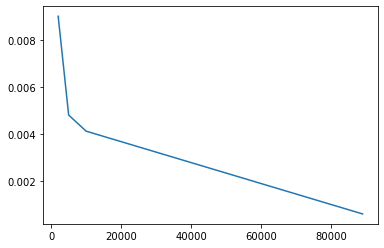

In [24]:
# построим график
x = [2000, 5000, 10000, data.item_id.nunique()]
y = [y1, y2, y3, result.apply(lambda row: precision_at_k(row['random_recommendation'], row['actual']), axis=1).mean()]
plt.plot(x, y)

Видим, что случайный выбор из популярных товаров дает значение метрики тем больше, чем меньше выборка этих товаров. Это логично, так как популярные товары покупают лучше, но может быть бесполезным, так как высока вероятность того, что этот товар купят без рекомендаций.

In [25]:
# метрика по популярным товарам будет одинаковой для всех размеров топ-выборки, так как берем первых 5
# рассчитаем взвешенные случайные рекомендации для топов

In [26]:
items_weights_2000 = popularity[:2000].copy()
items_weights_2000['weight'] = items_weights_2000['sales_value'] / items_weights_2000['sales_value'].sum()
items_weights_2000.drop('sales_value', axis=1, inplace=True)
result['weighted_random_recommendation_2000'] = result['user_id'].apply(lambda x: weighted_random_recommendation(items_weights_2000, n=5))

In [27]:
items_weights_5000 = popularity[:5000].copy()
items_weights_5000['weight'] = items_weights_5000['sales_value'] / items_weights_5000['sales_value'].sum()
items_weights_5000.drop('sales_value', axis=1, inplace=True)
result['weighted_random_recommendation_5000'] = result['user_id'].apply(lambda x: weighted_random_recommendation(items_weights_5000, n=5))

In [28]:
items_weights_10000 = popularity[:10000].copy()
items_weights_10000['weight'] = items_weights_10000['sales_value'] / items_weights_10000['sales_value'].sum()
items_weights_10000.drop('sales_value', axis=1, inplace=True)
result['weighted_random_recommendation_10000'] = result['user_id'].apply(lambda x: weighted_random_recommendation(items_weights_10000, n=5))

In [29]:
# посчитаем метрики precision_at_k:
y1 = result.apply(lambda row: precision_at_k(row['weighted_random_recommendation_2000'], row['actual']), axis=1).mean()
y1

0.04329089128305611

In [30]:
y2 = result.apply(lambda row: precision_at_k(row['weighted_random_recommendation_5000'], row['actual']), axis=1).mean()
y2

0.030166503428011873

In [31]:
y3 = result.apply(lambda row: precision_at_k(row['weighted_random_recommendation_10000'], row['actual']), axis=1).mean()
y3

0.026738491674828693

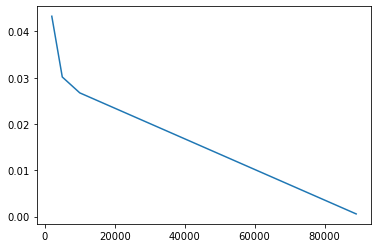

In [32]:
# построим график
x = [2000, 5000, 10000, data.item_id.nunique()]
y = [y1, y2, y3, result.apply(lambda row: precision_at_k(row['random_recommendation'], row['actual']), axis=1).mean()]
plt.plot(x, y)

Видим, что график ведет себя так же, как и для случайных рекомендаций, только значения метрик по соответствующим топам выше.

In [33]:
# Попробуйте улучшить разные варианты ItemItemRecommender, выбирая число соседей  𝐾 . 
# Постройте график зависимости precision@5 от 𝐾
popularity_q = data_train.groupby('item_id')['quantity'].sum().reset_index()
popularity_q.rename(columns={'quantity': 'n_sold'}, inplace=True)
top_5000 = popularity_q.sort_values('n_sold', ascending=False).head(5000).item_id.tolist()
# Заведем фиктивный item_id (если юзер покупал товары из топ-5000, то он "купил" такой товар)
data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999999

user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity',
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix[user_item_matrix > 0] = 1 # так как в итоге хотим предсказать 
user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

# переведем в формат saprse matrix
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

user_item_matrix.shape

(2499, 5001)

In [34]:
userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

In [35]:
# если запускать циклом, ядро умирает, делаю по очереди
# K=1 - это own_purchases, посчитаем для K от 2 до 7, кроме K=5 (это столбец itemitem)
model = ItemItemRecommender(K=2, num_threads=4) # K - кол-во билжайших соседей

model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

result['itemitem2'] = result['user_id'].\
    apply(lambda x: [id_to_itemid[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id[x], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=5, 
                                    filter_already_liked_items=True, 
                                    filter_items=None, 
                                    recalculate_user=True)])

In [36]:
model = ItemItemRecommender(K=3, num_threads=4) # K - кол-во билжайших соседей

model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

result['itemitem3'] = result['user_id'].\
    apply(lambda x: [id_to_itemid[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id[x], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=5, 
                                    filter_already_liked_items=True, 
                                    filter_items=None, 
                                    recalculate_user=True)])

In [37]:
model = ItemItemRecommender(K=4, num_threads=4) # K - кол-во билжайших соседей

model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

result['itemitem4'] = result['user_id'].\
    apply(lambda x: [id_to_itemid[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id[x], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=5, 
                                    filter_already_liked_items=True, 
                                    filter_items=None, 
                                    recalculate_user=True)])

In [38]:
model = ItemItemRecommender(K=6, num_threads=4) # K - кол-во билжайших соседей

model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

result['itemitem6'] = result['user_id'].\
    apply(lambda x: [id_to_itemid[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id[x], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=5, 
                                    filter_already_liked_items=True, 
                                    filter_items=None, 
                                    recalculate_user=True)])

In [39]:
model = ItemItemRecommender(K=7, num_threads=4) # K - кол-во билжайших соседей

model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

result['itemitem7'] = result['user_id'].\
    apply(lambda x: [id_to_itemid[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id[x], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=5, 
                                    filter_already_liked_items=True, 
                                    filter_items=None, 
                                    recalculate_user=True)])

In [40]:
y2 = result.apply(lambda row: precision_at_k(row['itemitem2'], row['actual']), axis=1).mean()
y2

0.05949232778321952

In [41]:
y3 = result.apply(lambda row: precision_at_k(row['itemitem3'], row['actual']), axis=1).mean()
y3

0.05827619980411406

In [42]:
y4 = result.apply(lambda row: precision_at_k(row['itemitem4'], row['actual']), axis=1).mean()
y4

0.0412340842311462

In [43]:
y5 = result.apply(lambda row: precision_at_k(row['itemitem'], row['actual']), axis=1).mean()
y5

0.15112634671890113

In [44]:
y6 = result.apply(lambda row: precision_at_k(row['itemitem6'], row['actual']), axis=1).mean()
y6

0.03183153770812942

In [45]:
y7 = result.apply(lambda row: precision_at_k(row['itemitem7'], row['actual']), axis=1).mean()
y7

0.03134182174338897

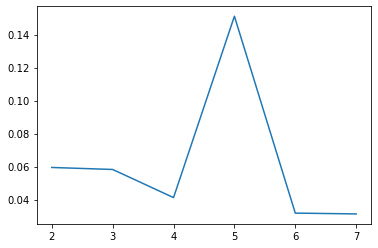

In [46]:
# построим график
x = [K for K in range(2, 8)]
y = [y2, y3, y4, y5, y6, y7]
plt.plot(x, y)

Честно говоря, не понимаю, почему такие результаты и график. 
По логике, должны быть чем ближе, тем точнее, а по расчетам получается, что K=5 - оптимальное количество соседей, а варианты больше или меньше дают результат радикально хуже.